In [90]:
import pandas as pd;
#读入表格

data=pd.read_csv('titanic.csv')

print(data.head(5))

   PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                                           Name     Sex   Age  SibSp  Parch  \
0                              Kelly, Mr. James    male  34.5      0      0   
1              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                     Myles, Mr. Thomas Francis    male  62.0      0      0   
3                              Wirz, Mr. Albert    male  27.0      0      0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   

    Ticket     Fare Cabin Embarked  
0   330911   7.8292   NaN        Q  
1   363272   7.0000   NaN        S  
2   240276   9.6875   NaN        Q  
3   315154   8.6625   NaN        S  
4  3101298  12.2875   NaN        S  


创建一个字典对应列名**中英文关系**

In [91]:
meaning={'PassengerId':'（乘客编号）',
'Survived':'（是否幸存）',
'Pclass':'（舱位等级）',
'Name':'（姓名）',
'Sex':'（性别）',
'Age':'（年龄）',
'SibSp':'（兄弟姐妹/配偶数量）',
'Parch':'（父母/子女数量）',
'Ticket':'（船票号码）',
'Fare':'（票价）',
'Cabin':'（船舱号）',
'Embarked':'（登船港口）'}


# 删除冗余数据，处理缺失值

In [92]:
#删除不需要的列
columns_to_drop=['PassengerId','Name','Ticket','SibSp','Parch']
#删除不需要的列后的数据
data_reduced=data.drop(columns=columns_to_drop,axis=1)



In [93]:
#查看缺失值
print(data_reduced.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age          86
Fare          1
Cabin       327
Embarked      0
dtype: int64


**船舱号**有大量缺失值，失去意义，删去

In [94]:
data_reduced.drop(columns=['Cabin'],axis=1,inplace=True)


In [95]:
print(data_reduced.columns.to_list())

['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']


In [96]:
#用中位数填充年龄缺失值
data_reduced['Age']=data_reduced['Age'].fillna(data_reduced['Age'].median())

print(data_reduced['Age'].isnull().sum())

0


In [97]:
#定位fare缺失值所在的行
print(data_reduced[data_reduced['Fare'].isnull()])

     Survived  Pclass   Sex   Age  Fare Embarked
152         0       3  male  60.5   NaN        S


In [98]:
#用相同舱位等级的乘客的票价中位数填充缺失值
pclass3_fare_median=data_reduced[data_reduced['Pclass']==3]['Fare'].median()
print(pclass3_fare_median)
data_reduced['Fare']=data_reduced['Fare'].fillna(pclass3_fare_median)

7.8958


In [99]:
#查看缺失值
print(data_reduced.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
dtype: int64


# 数据转换
## 分类变量编码
### 对Sex列标签编码

In [100]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder();
data_reduced["Sex_encoded"]=le.fit_transform(data_reduced['Sex'])
print(data_reduced[['Sex_encoded','Sex']].head(5))

   Sex_encoded     Sex
0            1    male
1            0  female
2            1    male
3            1    male
4            0  female


可以看出`fit_transform`将0和male对应，1和female对应

### 对Embarked列独热编码

In [101]:
embarked_dummies=pd.get_dummies(data_reduced['Embarked'],prefix='Embarked')

data_reduced=pd.concat([data_reduced,embarked_dummies],axis=1)

print(embarked_dummies.head(5))
print(data_reduced[['Embarked_C','Embarked_Q','Embarked_S']].head(5))

   Embarked_C  Embarked_Q  Embarked_S
0       False        True       False
1       False       False        True
2       False        True       False
3       False       False        True
4       False       False        True
   Embarked_C  Embarked_Q  Embarked_S
0       False        True       False
1       False       False        True
2       False        True       False
3       False       False        True
4       False       False        True


## 连续变量分箱
### 将年龄分为儿童/成人/老人

In [102]:
# 定义分箱边界和标签
bins = [0, 12, 18, 60, 100]
labels = ['Child', 'Teen', 'Adult', 'Elderly']

data_reduced['AgeGroup']=pd.cut(data_reduced['Age'],bins=bins, labels=labels)
print(data_reduced[['Age','AgeGroup']].head(5))

    Age AgeGroup
0  34.5    Adult
1  47.0    Adult
2  62.0  Elderly
3  27.0    Adult
4  22.0    Adult


## 特征缩放

In [103]:
#归一化
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

data_reduced['Age_scaled']=scaler.fit_transform(data_reduced[['Age']])
data_reduced['Fare_scaled']=scaler.fit_transform(data_reduced[['Fare']])
print(data_reduced[['Age_scaled','Fare_scaled']].head(5))

   Age_scaled  Fare_scaled
0    0.452723     0.015282
1    0.617566     0.013663
2    0.815377     0.018909
3    0.353818     0.016908
4    0.287881     0.023984


# 数学建模建立预测模型（随机森林）

In [104]:
#查看数据
print(data_reduced.head(5))



   Survived  Pclass     Sex   Age     Fare Embarked  Sex_encoded  Embarked_C  \
0         0       3    male  34.5   7.8292        Q            1       False   
1         1       3  female  47.0   7.0000        S            0       False   
2         0       2    male  62.0   9.6875        Q            1       False   
3         0       3    male  27.0   8.6625        S            1       False   
4         1       3  female  22.0  12.2875        S            0       False   

   Embarked_Q  Embarked_S AgeGroup  Age_scaled  Fare_scaled  
0        True       False    Adult    0.452723     0.015282  
1       False        True    Adult    0.617566     0.013663  
2        True       False  Elderly    0.815377     0.018909  
3       False        True    Adult    0.353818     0.016908  
4       False        True    Adult    0.287881     0.023984  


In [105]:
#划分特征和目标变量
y=data_reduced['Survived']
features=['Pclass','Sex_encoded','Age_scaled','Fare_scaled','Embarked_C','Embarked_Q','Embarked_S']
x=data_reduced[features]

In [106]:
#划分训练集和测试集
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=666)

print("训练集大小:",x_train.shape)
print("测试集大小:",x_test.shape)

训练集大小: (334, 7)
测试集大小: (84, 7)


In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model=RandomForestClassifier(n_estimators=5,random_state=666)

model.fit(x_train,y_train)
y_pred=model.predict(x_test)

In [111]:
accuracy=accuracy_score(y_test,y_pred)
print("模型准确率:",accuracy)

importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': x.columns, 'Importance': importances})
#print(feature_importance.head(5))


模型准确率: 1.0


       Feature  Importance
1  Sex_encoded    0.886936
3  Fare_scaled    0.055245
2   Age_scaled    0.039255
5   Embarked_Q    0.010597
0       Pclass    0.006387
6   Embarked_S    0.000963
4   Embarked_C    0.000618


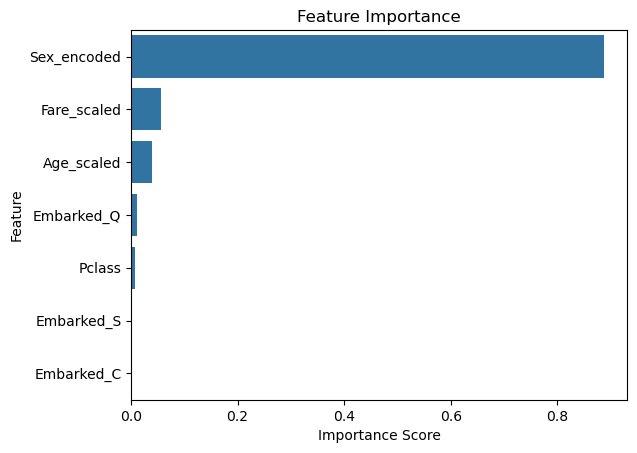

In [109]:
feature_importance=feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()